In [2]:
import torch
import segmentation_models_pytorch as smp
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import rasterio
import subprocess
import random
import cv2
import albumentations as albu
from PIL import Image
from glob import glob
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# Based on example notebook (FPN) provided by segmentation_models_pytorch dev
# https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples

In [4]:
#importing notebooks
#from ipynb.fs.full.<notebook_name> import *
from ipynb.fs.full.create_seg_dataset import create_seg_dataset
from ipynb.fs.full.gen_seg_labels import gen_seg_labels, tif_to_jpg, tile_raster
from ipynb.fs.full.raster_mask import raster_mask

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(9, 4))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
# defining our dataset helper class for extraction, transformation and preprocessing
# https://pytorch.org/docs/stable/data

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list[str]): list of ids for images, mirrors and masks
        images_dir (str): dirctory where images are stored
        masks_dir (str): directory where masks are stored
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['mangrove']
    
    def __init__(
            self, 
            ids,
            images_dir,
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, "image" + image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, "annotation" + mask_id) for mask_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        
        # uncomment to check paths are correct
        #print(f"filepath of image is {self.images_fps[i]} ")
        #print(f"filepath of mask is {self.masks_fps[i]} ")

        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [7]:
# loading in full dataset and splitting it into training and testing
def split_dataset(img_dir, mask_dir, augmentation=None, preprocessing=None):

    """takes img_dir and mask_dir and shuffles then splits(80/20... etc) into training and validation
    Dataset(s), defined  above ^^^ 
    
    Args:
        img_dir (str): path to images folder
        mask_dir (str): path to masks folder
        augmentation (albumetations.Compose): data transformation pipeline
            (flip, scale, etc)
        preprocessing (albumentations.Compose): data preprocessing
            (normalization, shape manipulation, etc)
    
    returns:
        train_dataset (Dataset), val_dataset (Dataset)
    """

    SEED = 42
    training_data = "../dataset/training/"
    img_ids = [f for f in os.listdir(training_data + "images") if f.endswith(".jpg")]
    #img_ids = glob(training_data + "images/*.jpg") # masks will have corresponding ids
    DATASET_SIZE = len(img_ids)
    print(f"The Training Dataset contains {DATASET_SIZE} images.")

    TRAIN_SIZE = int(0.8 * DATASET_SIZE)
    VAL_SIZE = int(0.2 * DATASET_SIZE)

    print("Shuffling ids...")
    random.seed(SEED)
    random.shuffle(img_ids)
    print("Done")
    
    ids = [id[5:] for id in img_ids] # strip off "image" in ["image_01.jpg", "image_02.jpg", ...]
    
    train_ids = ids[0:TRAIN_SIZE] # split datasets
    val_ids = ids[TRAIN_SIZE:DATASET_SIZE + 1]
    
    #print(f"There are {len(train_ids)} training images")
    #print(f"and {len(val_ids)} validation images")

    train_dataset = Dataset(train_ids, img_dir, mask_dir, ['mangrove'], augmentation, preprocessing)
    val_dataset = Dataset(val_ids, img_dir, mask_dir, ['mangrove'], augmentation, preprocessing)
    
    return train_dataset, val_dataset

In [8]:
def get_training_augmentation():
    train_transform = [

         albu.HorizontalFlip(p=0.5)

# Taken from segmentation_models example not sure if we want to use these different augmentatons

#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=320, width=320, always_apply=True),

#         albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),

#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
#                 albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256) # may need to change width
    ]
    return albu.Compose(test_transform)


def to_tensor(xx, **kwargs):
    return xx.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
#delete all files with extension
# folderpath = "../dataset/training/images/"
# for file_name in os.listdir(folderpath):
#     #4
#     if file_name.endswith('.jpg'):
#         #5
#         os.remove(folderpath + file_name)

In [10]:
# Create Model
ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['mangrove']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
# create dataset, assuming tiling has already occurred

mask_dir = "../dataset/training/annotations"
img_dir = "../dataset/training/images"

train_dataset, val_dataset = split_dataset(
    img_dir,
    mask_dir,
    #preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=None
)

The Training Dataset contains 4048 images.
Shuffling ids...
Done


In [12]:
# load datasets

# batch_size and num_workers can be optimized later on

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [13]:
sum = 0
for data in train_dataset:    
    mask = data[1]
    if np.mean(mask) < .5:
        sum += 1
                
        visualize(
        image=data[0], 
        ground_truth_mask=mask.squeeze(), 
        )
        print(mask)
print(sum)


0


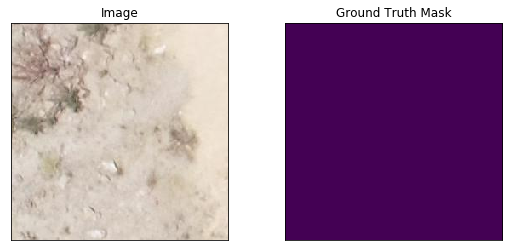

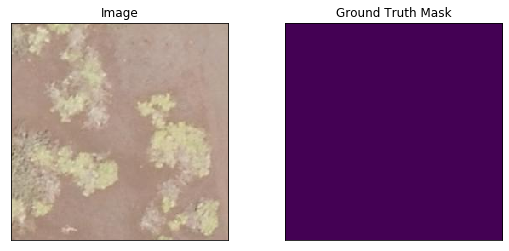

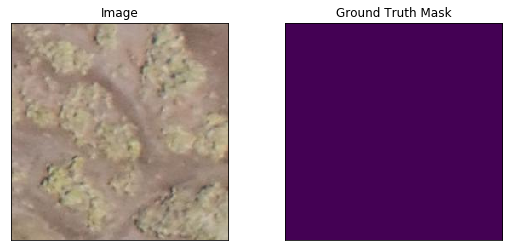

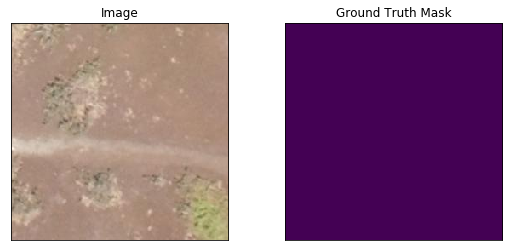

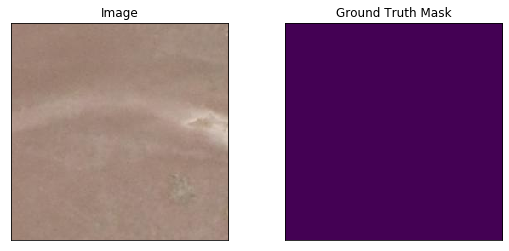

In [16]:
for i in range(5):
    n = np.random.choice(len(train_dataset))
    
    image_vis = train_dataset[n][0].astype('uint8')
    image, gt_mask = train_dataset[n]
    
    
    #print(gt_mask)
    gt_mask = gt_mask.squeeze()
    gt_mask = gt_mask * 255.0
    #x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    #pr_mask = best_model.predict(x_tensor)
    #pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
     #   predicted_mask=pr_mask
    )

(256, 256, 3)
(256, 256, 1)


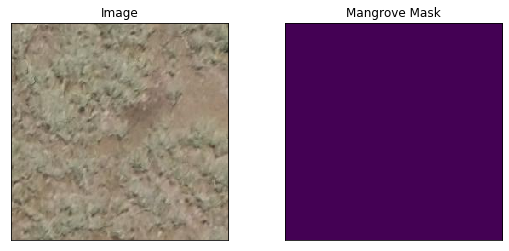

In [143]:
#visualize data
image, mask = train_dataset[485]
print(image.shape)
print(mask.shape)
visualize(image=image, mangrove_mask=mask.squeeze())
    #cannot visualize data with preproccessing, as it reshapes tensor


In [23]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5), # threshold is default... 
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001), # learning rate is deafult...
])

In [24]:
#create epoch runners 
#it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

val_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.94 GiB total capacity; 1017.00 KiB already allocated; 9.00 MiB free; 2.00 MiB reserved in total by PyTorch)

In [16]:
#checking size/shape of tensors

#npa = np.asarray((next(iter(train_loader))))
element = (next(iter(train_loader)))
print(type(element[0]))
print(element[0].size())
#print(npa)


<class 'torch.Tensor'>
torch.Size([8, 3, 256, 256])


In [17]:
'''Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. 
Note: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has).
>>> torch.Size([32])
    # 1d: [batch_size] 
    # use for target labels or predictions.
>>> torch.Size([12, 256])
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # use for as nn.Linear() input.
>>> torch.Size([10, 1, 2048])
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # when used as nn.Conv1d() input.
    # (but [seq_len, batch_size, num_features]
    # if feeding an RNN).
>>> torch.Size([16, 3, 28, 28])
    # 4d: [batch_size, channels, height, width]
    # use for as nn.Conv2d() input.
>>>  torch.Size([32, 1, 5, 15, 15])
    # 5D: [batch_size, channels, depth, height, width]
    # use for as nn.Conv3d() input.'''


'Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. \nNote: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has).\n>>> torch.Size([32])\n    # 1d: [batch_size] \n    # use for target labels or predictions.\n>>> torch.Size([12, 256])\n    # 2d: [batch_size, num_features (aka: C * H * W)]\n    # use for as nn.Linear() input.\n>>> torch.Size([10, 1, 2048])\n    # 3d: [batch_size, channels, num_features (aka: H * W)]\n    # when used as nn.Conv1d() input.\n    # (but [seq_len, batch_size, num_features]\n    # if feeding an RNN).\n>>> torch.Size([16, 3, 28, 28])\n    # 4d: [batch_size, channels, height, width]\n    # use for as nn.Conv2d() input.\n>>>  torch.Size([32, 1, 5, 15, 15])\n    # 5D: [batch_size, channels, depth, height, width]\n    # use for as nn.Conv3d() input.'

In [34]:
# train model for 40 epochs
import time
max_score = 0

start = time.time()
now = datetime.now()
date = str(now.month) + "_" + str(now.day) + "_"
save_loc = '../dataset/pytorch_models/' + date + 'best_model.pth'

for i in range(0, 40):
    
    epoch_start = time.time()
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    val_logs = val_epoch.run(val_loader)
    elapsed = time.time() - epoch_start
    print("Elapsed Time(s): ", int(elapsed))
    # do something (save model, change lr, etc.)
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, save_loc)
        print('\033[1mModel saved! \033[0m')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decreased decoder learning rate to 1e-5! \033[0m')


Epoch: 0
valid: 100%|██████████| 597/597 [00:10<00:00, 55.99it/s, dice_loss - 0.09972, iou_score - 0.9291]
Elapsed Time(s):  117
Model saved! 

Epoch: 1
valid: 100%|██████████| 597/597 [00:10<00:00, 56.10it/s, dice_loss - 0.07401, iou_score - 0.9322]
Elapsed Time(s):  117
Model saved! 

Epoch: 2
valid: 100%|██████████| 597/597 [00:10<00:00, 55.90it/s, dice_loss - 0.06302, iou_score - 0.9316]
Elapsed Time(s):  117

Epoch: 3
train:  50%|████▉     | 149/299 [00:53<00:54,  2.77it/s, dice_loss - 0.02071, iou_score - 0.9776]


KeyboardInterrupt: 

In [19]:
#load best saved checkpoint
best_model = torch.load(save_loc)
train_dataset_vis, val_dataset_vis = split_dataset(
    img_dir,
    mask_dir,
    #preprocessing=get_preprocessing(preprocessing_fn), for visualizing
    augmentation=None
)

The Training Dataset contains 2985 images.
Shuffling ids...
Done


In [156]:
for i in range(5):
    n = np.random.choice(len(val_dataset))
    
    image_vis = val_dataset_vis[n][0].astype('uint8')
    image, gt_mask = val_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

error: OpenCV(4.3.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
